In [79]:
!pip install xgboost lightgbm catboost
!pip install category_encoders

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import os
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import RegressorMixin, BaseEstimator

In [81]:
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [82]:
print(os.listdir('drive/MyDrive/math_basis_of_ai/RestaurantRevenuePrediction'))
PATH = 'drive/MyDrive/math_basis_of_ai/RestaurantRevenuePrediction/'
df_train = pd.read_csv(f'{PATH}train.csv', parse_dates=['Open Date'])
df_test = pd.read_csv(f'{PATH}test.csv', parse_dates=['Open Date'])

['train.csv', 'test.csv', 'sampleSubmission.csv']


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
def score(model, X_train, y_train, X_valid = [], y_valid = []):
    rmse = sqrt(mean_squared_error(np.square(np.exp(y_train)), np.square(np.exp(model.predict(X_train)))))
    score = [rmse, model.score(X_train, y_train)]

    if len(X_valid) != 0 and len(y_valid) != 0:
        score.append(sqrt(mean_squared_error(np.square(np.exp(y_valid)), np.square(np.exp(model.predict(X_valid))))))

    if model.oob_score:
        score.append(model.oob_score_)

    return score

In [85]:
def add_datepart(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df[date_col + '_Year'] = df[date_col].dt.year
    df[date_col + '_Month'] = df[date_col].dt.month
    df[date_col + '_Week'] = df[date_col].dt.isocalendar().week
    df[date_col + '_Day'] = df[date_col].dt.day
    df[date_col + '_Dayofweek'] = df[date_col].dt.dayofweek
    df[date_col + '_Dayofyear'] = df[date_col].dt.dayofyear
    df[date_col + '_Is_month_end'] = df[date_col].dt.is_month_end
    df[date_col + '_Is_month_start'] = df[date_col].dt.is_month_start
    df[date_col + '_Is_quarter_end'] = df[date_col].dt.is_quarter_end
    df[date_col + '_Is_quarter_start'] = df[date_col].dt.is_quarter_start
    df[date_col + '_Is_year_end'] = df[date_col].dt.is_year_end
    df[date_col + '_Is_year_start'] = df[date_col].dt.is_year_start
    df[date_col + '_Elapsed'] = (pd.Timestamp.now() - df[date_col]).dt.days  # Дні з моменту дати
    df.drop(columns=[date_col], inplace=True)

In [86]:
def convert_cats(df):
    if "City" in df.columns:
        encoder = BinaryEncoder(cols=["City"])
        binary_encoded = encoder.fit_transform(df)
        for col in binary_encoded.columns:
            if col not in df.columns:
                df[col] = binary_encoded[col]
        df.drop(columns=["City"], inplace=True, errors="ignore")
    for col in df.select_dtypes(['object']).columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

In [87]:
def clean_and_split_df(df, y_col=None):
    df = df.copy()
    y = None
    if y_col is not None:
        y = df[y_col]
        df.drop(columns=[y_col], inplace=True)

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype == 'object':
                df[col] = df[col].fillna('missing')
            else:
                df[col] = df[col].fillna(df[col].median())
    convert_cats(df)
    removed_cols = []
    if 'Id' in df.columns:
        removed_cols.append('Id')
        df.drop(columns=['Id'], inplace=True)

    return df, y, removed_cols

In [88]:
# Кількість записів у тренувальному наборі '''''''
n_train = df_train.shape[0]

def merge_and_process_data(df_train, df_test, fe=[]):
    df = pd.concat([df_train.drop('revenue', axis=1), df_test], axis=0)
    convert_cats(df)

    if 'city' in fe:
        df = df.drop('City', axis=1, errors='ignore')

    if 'city_group' in fe:
        df = df.drop('City Group', axis=1, errors='ignore')

    if 'dummies' in fe:
        p_cols = [f'P{n}' for n in range(1, 38)]
        df = pd.get_dummies(df, columns=p_cols, drop_first=True)
        if 'city_group' not in fe:
            df = pd.get_dummies(df, columns=['City Group'], drop_first=True)

        df = pd.get_dummies(df, columns=['Type'], drop_first=True)

    add_datepart(df, 'Open Date')
    X, _, _ = clean_and_split_df(df)
    drop_cols = [
        'Open Year', 'P26', 'P25', 'P9', 'P10', 'P16', 'P36', 'P34','P32', 'Open Month', 'Open Date_Month', 'P12', 'P18','P15', 'P33', 'Open Week', 'Open Day',
        'Open Dayofyear', 'Open Is_month_end', 'Open Is_month_start',
        'Open Is_quarter_end', 'Open Is_quarter_start',
        'Open Is_year_start'
    ]
    drop_cols = [col for col in drop_cols if col in X.columns]
    X = X.drop(drop_cols, axis=1)

    if 'id' in fe:
        X = X.drop('Id', axis=1, errors='ignore')

    if 'scale_open' in fe:
        if 'Open Elapsed' in X.columns:
            X['Open Elapsed'] = (X['Open Elapsed'] / 1000).apply(np.log)

    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test


In [89]:
model_list = [
    ("RandomForest", RandomForestRegressor(n_estimators=100, max_features=0.5, n_jobs=-1, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("LightGBM", LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)),
    ("CatBoost", CatBoostRegressor(n_estimators=100, random_state=42, verbose=0))
]

In [90]:
def train_cv(X, y, model_list):
    results = {}

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    for model_name, model_obj in model_list:
        print(f"Тренуємо модель: {model_name}")
        models = []
        scores = []

        for train_index, val_index in kf.split(X_scaled):
            X_train_ = X_scaled[train_index]
            y_train_ = y.iloc[train_index].to_numpy()
            X_val_ = X_scaled[val_index]
            y_val_ = y.iloc[val_index].to_numpy()

            model = model_obj
            model.fit(X_train_, y_train_)
            models.append(model)

            y_pred = model.predict(X_val_)
            rmse = calculate_rmse(y_val_, y_pred)
            scores.append(rmse)

        mean_rmse = np.mean(scores)
        results[model_name] = (models, mean_rmse)
        print(f"Модель {model_name}: Середній RMSE = {mean_rmse:.4f}")

    return results

In [91]:
def plot_model_performance(results):
    """Створює графік порівняння моделей за середнім RMSE."""
    model_names = list(results.keys())
    rmse_values = [results[name][1] for name in model_names]

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, rmse_values, alpha=0.7)
    plt.title("Порівняння моделей за RMSE", fontsize=14)
    plt.xlabel("Моделі", fontsize=12)
    plt.ylabel("Середній RMSE", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [92]:
def predict(models, X):
    f = 1 / len(models)
    pred = 0
    for m in models:
        pred += f * m.predict(X)

    return pred

In [93]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom Neural Network

In [94]:
class CustomNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Ініціалізація ваг і зсувів
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)

        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = self.sigmoid(self.final_input)

        return self.final_output

    def backward(self, X, y, output):
        """Зворотне поширення помилки за допомогою стандартного градієнтного спуску."""
        # Помилка на виході
        output_error = y - output
        output_delta = output_error * self.sigmoid_derivative(output)

        # Помилка на прихованому шарі
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.relu_derivative(self.hidden_output)  # Використовуємо похідну ReLU

        # Оновлення ваг
        self.weights_input_hidden += self.learning_rate * np.dot(X.T, hidden_delta)
        self.bias_hidden += self.learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)
        self.weights_hidden_output += self.learning_rate * np.dot(self.hidden_output.T, output_delta)
        self.bias_output += self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                loss = np.mean((y - output) ** 2)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return self.forward(X)

In [101]:
X_train, X_test = merge_and_process_data(df_train.copy(), df_test.copy())
y = df_train['revenue'].copy().apply(np.log)
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


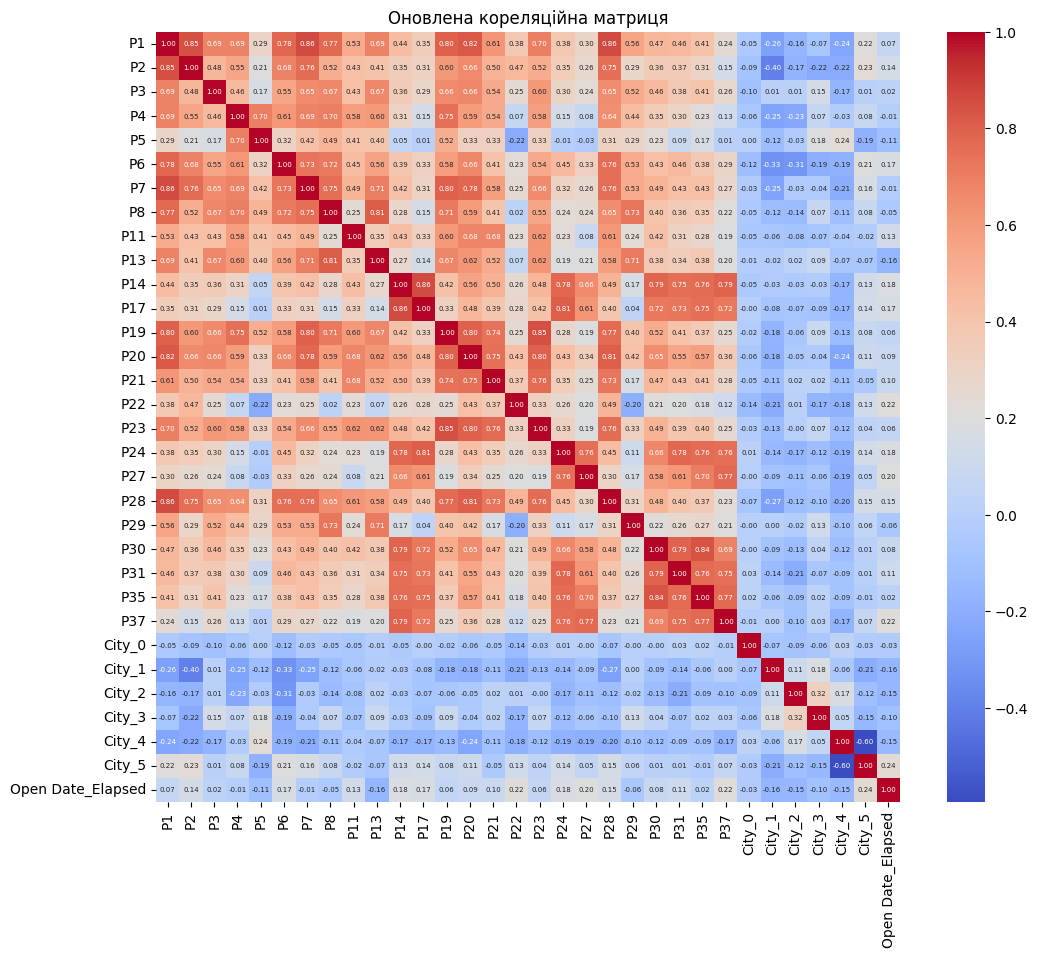

In [96]:
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = X_train[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 5})
plt.title("Оновлена кореляційна матриця")
plt.show()

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn = CustomNeuralNetwork(X_train_scaled.shape[1], 50, 1, learning_rate=0.001, epochs=1000)
nn.fit(X_train_scaled, y_train.to_numpy().reshape(-1, 1))

y_pred_nn = nn.predict(X_test_scaled)

y_test_actual = np.exp(np.sqrt(y_test.to_numpy().reshape(-1, 1)))
y_pred_nn_actual = np.exp(np.sqrt(y_pred_nn))

rmse_nn_test = calculate_rmse(y_test_actual, y_pred_nn_actual)
print(f"RMSE для кастомної нейронної мережі на тестових даних: {rmse_nn_test:.4f}")

Epoch 0, Loss: 215.8095897398026
Epoch 100, Loss: 201.4045458544248
Epoch 200, Loss: 201.3851282216967
Epoch 300, Loss: 201.38006159739643
Epoch 400, Loss: 201.37783341656518
Epoch 500, Loss: 201.37660491054925
Epoch 600, Loss: 201.37583481572537
Epoch 700, Loss: 201.37531007825595
Epoch 800, Loss: 201.37493204605454
Epoch 900, Loss: 201.37464775894216
RMSE для кастомної нейронної мережі на тестових даних: 46.8642


In [98]:
X_train = X_train.astype('float64')
X_train = X_train.to_numpy()  # Перетворення DataFrame на numpy масив
y_train = y_train.to_numpy().reshape(-1, 1)  # Перетворення Series на numpy масив і зміна форми
X_test = X_test.astype('float64')

nn = CustomNeuralNetwork(X_train.shape[1], 50, 1, learning_rate=0.01, epochs=1001)
nn.fit(X_train, y_train)

y_pred_nn = nn.predict(X_test)

rmse_nn_test = calculate_rmse(y_test, y_pred_nn)
print(f"RMSE для кастомної нейронної мережі на тестових даних: {rmse_nn_test:.4f}")

Epoch 0, Loss: 207.9053649628454
Epoch 100, Loss: 201.37280402903906
Epoch 200, Loss: 201.37280402903906
Epoch 300, Loss: 201.37280402903906
Epoch 400, Loss: 201.37280402903906
Epoch 500, Loss: 201.37280402903906
Epoch 600, Loss: 201.37280402903906
Epoch 700, Loss: 201.37280402903906
Epoch 800, Loss: 201.37280402903906
Epoch 900, Loss: 201.37280402903906
Epoch 1000, Loss: 201.37280402903906
RMSE для кастомної нейронної мережі на тестових даних: 14.2135


In [99]:
rf_model_list = [
    ("RandomForest", RandomForestRegressor(n_jobs=-1, n_estimators=150, oob_score=True, max_features=0.5))
]

In [102]:
results_rf = train_cv(X_train, y_train, rf_model_list)
best_model_rf_name, (best_models_rf, rmse_rf) = min(results_rf.items(), key=lambda x: x[1][1])
y_pred_rf = best_models_rf[0].predict(X_test)
print(f"RMSE для моделі 1 (Random Forest): {rmse_rf}")

Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.4218
RMSE для моделі 1 (Random Forest): 0.42176904509400337


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [103]:
results_model_list = train_cv(X_train, y_train, model_list)
best_model_list_name, (best_models_list, rmse_list) = min(results_model_list.items(), key=lambda x: x[1][1])
y_pred_list = best_models_list[0].predict(X_test)
print(f"RMSE для моделі 2 (CV): {rmse_list}")

Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.4209
Тренуємо модель: XGBoost
Модель XGBoost: Середній RMSE = 0.4556
Тренуємо модель: LightGBM
Модель LightGBM: Середній RMSE = 0.4889
Тренуємо модель: CatBoost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Модель CatBoost: Середній RMSE = 0.4432
RMSE для моделі 2 (CV): 0.42093402894431126


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [104]:
X_train_dummies, X_test_dummies = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['dummies'])
y_train_dummies = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_dummies = train_cv(X_train_dummies, y_train_dummies, model_list)
best_model_dummies_name, (best_models_dummies, rmse_dummies) = min(results_dummies.items(), key=lambda x: x[1][1])
y_pred_dummies = best_models_dummies[0].predict(X_test_dummies)
print(f"RMSE для моделі 3 (Попередня обробка + CV): {rmse_dummies}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.2296
Тренуємо модель: XGBoost
Модель XGBoost: Середній RMSE = 0.2609
Тренуємо модель: LightGBM
Модель LightGBM: Середній RMSE = 0.2479
Тренуємо модель: CatBoost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Модель CatBoost: Середній RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE для моделі 3 (Попередня обробка + CV): 0.22958368148785877


In [105]:
X_train_scale, X_test_scale = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['id', 'dummies', 'scale_open'])
y_train_scale = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_scale = train_cv(X_train_scale, y_train_scale, model_list)
best_model_scale_name, (best_models_scale, rmse_scale) = min(results_scale.items(), key=lambda x: x[1][1])
y_pred_scale = best_models_scale[0].predict(X_test_scale)
print(f"RMSE для моделі 4 (Попередня обробка + CV): {rmse_scale}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.2296
Тренуємо модель: XGBoost
Модель XGBoost: Середній RMSE = 0.2609
Тренуємо модель: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Модель LightGBM: Середній RMSE = 0.2479
Тренуємо модель: CatBoost
Модель CatBoost: Середній RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE для моделі 4 (Попередня обробка + CV): 0.22958368148785874


In [106]:
X_train_city, X_test_city = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['id', 'dummies', 'city'])
y_train_city = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_city = train_cv(X_train_city, y_train_city, model_list)
best_model_city_name, (best_models_city, rmse_city) = min(results_city.items(), key=lambda x: x[1][1])
y_pred_city = best_models_city[0].predict(X_test_city)
print(f"RMSE для моделі 5 (Попередня обробка + CV): {rmse_city}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.2296
Тренуємо модель: XGBoost
Модель XGBoost: Середній RMSE = 0.2609
Тренуємо модель: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Модель LightGBM: Середній RMSE = 0.2479
Тренуємо модель: CatBoost
Модель CatBoost: Середній RMSE = 0.2322


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE для моделі 5 (Попередня обробка + CV): 0.22958368148785874


In [107]:
X_train_open, X_test_open = merge_and_process_data(df_train.copy(), df_test.copy(), fe=['scale_open'])
y_train_open = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)

results_open = train_cv(X_train_open, y_train_open, model_list)
best_model_open_name, (best_models_open, rmse_open) = min(results_open.items(), key=lambda x: x[1][1])
y_pred_open = best_models_open[0].predict(X_test_open)
print(f"RMSE для моделі 6 (Попередня обробка + CV): {rmse_open}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Тренуємо модель: RandomForest
Модель RandomForest: Середній RMSE = 0.2223
Тренуємо модель: XGBoost
Модель XGBoost: Середній RMSE = 0.2390
Тренуємо модель: LightGBM


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Модель LightGBM: Середній RMSE = 0.2345
Тренуємо модель: CatBoost
Модель CatBoost: Середній RMSE = 0.2311


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE для моделі 6 (Попередня обробка + CV): 0.22228921198251567


In [108]:
def analyze_results(results):
    model_names = []
    mean_rmse_values = []

    for model_name, (models, mean_rmse) in results.items():
        print(f"Модель: {model_name}")
        print(f"Кількість моделей (фолдів): {len(models)}")
        print(f"Середній RMSE: {mean_rmse:.4f}")
        print("-" * 40)

        model_names.append(model_name)
        mean_rmse_values.append(mean_rmse)
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, mean_rmse_values, color='skyblue')
    plt.xlabel("Середній RMSE")
    plt.ylabel("Моделі")
    plt.title("Продуктивність моделей")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

Модель: RandomForest
Кількість моделей (фолдів): 4
Середній RMSE: 0.2223
----------------------------------------
Модель: XGBoost
Кількість моделей (фолдів): 4
Середній RMSE: 0.2390
----------------------------------------
Модель: LightGBM
Кількість моделей (фолдів): 4
Середній RMSE: 0.2345
----------------------------------------
Модель: CatBoost
Кількість моделей (фолдів): 4
Середній RMSE: 0.2311
----------------------------------------


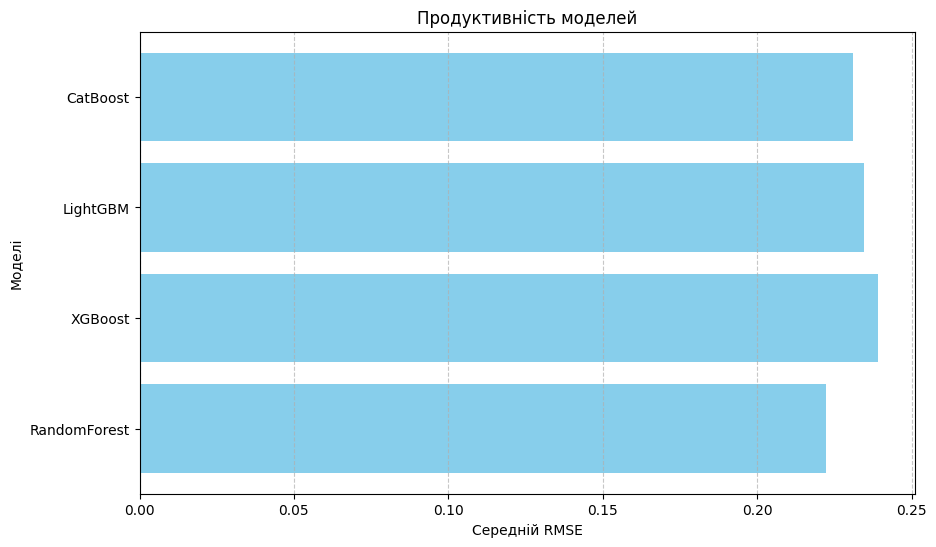

In [109]:
analyze_results(results_open)

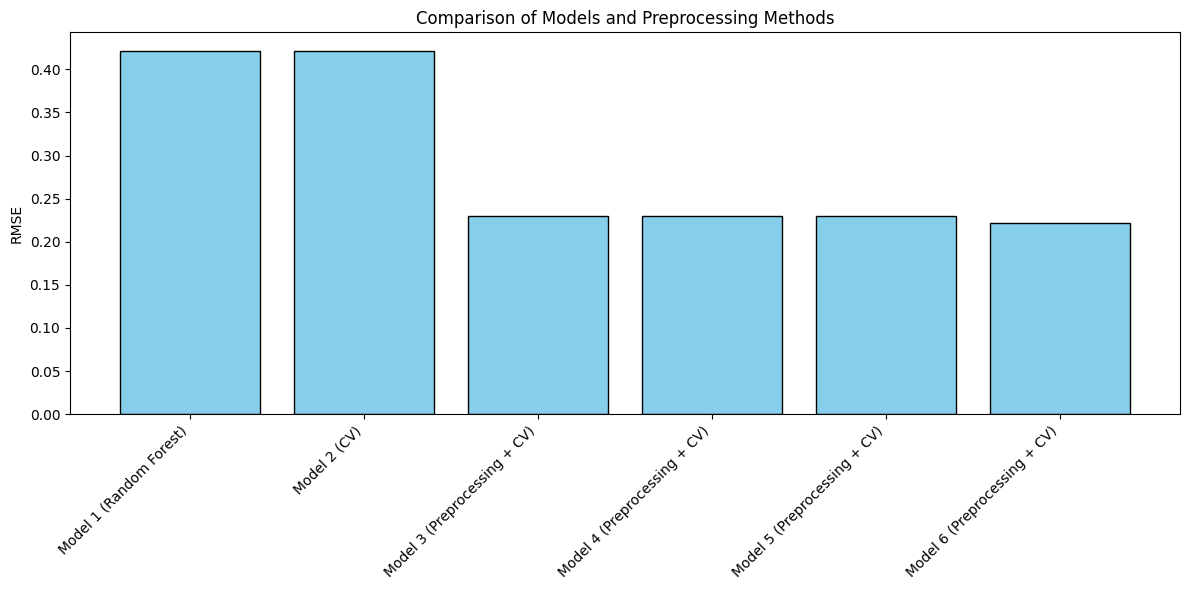

In [110]:
experiments = [
    {"name": "Model 1 (Random Forest)", "rmse": rmse_rf},
    {"name": "Model 2 (CV)", "rmse": rmse_list},
    {"name": "Model 3 (Preprocessing + CV)", "rmse": rmse_dummies},
    {"name": "Model 4 (Preprocessing + CV)", "rmse": rmse_scale},
    {"name": "Model 5 (Preprocessing + CV)", "rmse": rmse_city},
    {"name": "Model 6 (Preprocessing + CV)", "rmse": rmse_open},
]

names = [exp["name"] for exp in experiments]
rmses = [exp["rmse"] for exp in experiments]

plt.figure(figsize=(12, 6))
plt.bar(names, rmses, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Comparison of Models and Preprocessing Methods")
plt.tight_layout()

plt.show()

Найкраща модель: Model 6 (Preprocessing + CV + Scale Open Simple) з RMSE = 0.2223
Feature Importance для найкращої моделі:
                       Feature  Importance
37         Open Date_Dayofyear    0.115443
44           Open Date_Elapsed    0.114044
34              Open Date_Week    0.065419
21                         P28    0.063078
33              Open Date_Year    0.058423
35               Open Date_Day    0.046790
2                           P1    0.036608
36         Open Date_Dayofweek    0.034671
15                         P20    0.030706
14                         P19    0.029723
22                         P29    0.028090
7                           P6    0.026514
32                      City_5    0.025598
13                         P17    0.024385
17                         P22    0.024130
10                         P11    0.023127
3                           P2    0.021251
11                         P13    0.016193
9                           P8    0.016106
18               

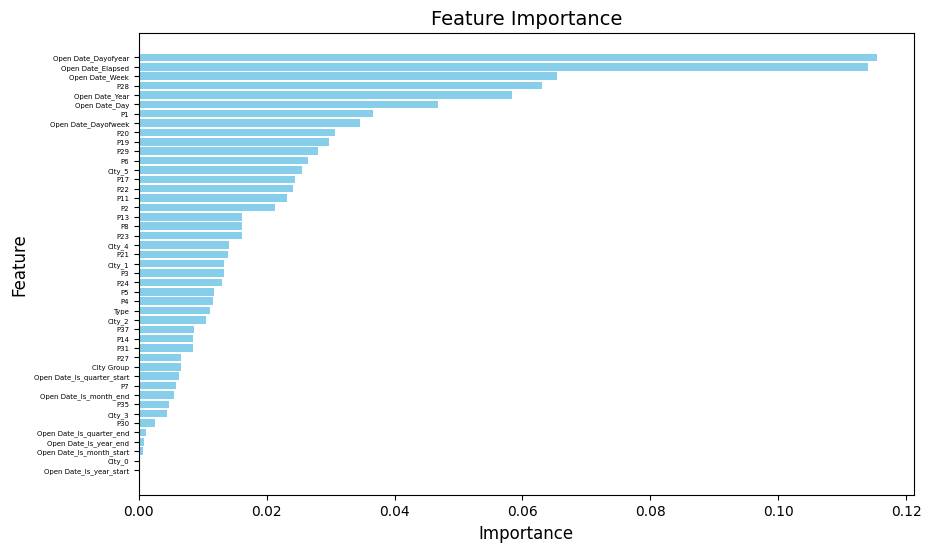

In [111]:
all_results = {
    "Model 1 (Random Forest)": (best_models_rf[0], rmse_rf),
    "Model 2 (CV)": (best_models_list[0], rmse_list),
    "Model 3 (Preprocessing + CV + Dummies)": (best_models_dummies[0], rmse_dummies),
    "Model 4 (Preprocessing + CV + Scale Open)": (best_models_scale[0], rmse_scale),
    "Model 5 (Preprocessing + CV + City)": (best_models_city[0], rmse_city),
    "Model 6 (Preprocessing + CV + Scale Open Simple)": (best_models_open[0], rmse_open)
}

best_model_name, (best_model, best_rmse) = min(all_results.items(), key=lambda x: x[1][1])

print(f"Найкраща модель: {best_model_name} з RMSE = {best_rmse:.4f}")
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print("Feature Importance для найкращої моделі:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="skyblue")
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title("Feature Importance", fontsize=14)
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=5)
    plt.show()